In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import lmdb
import pickle

import get_image_size as gis
import util

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [21]:
import sys
sys.path[0]

'C:\\Users\\Joshua\\classes\\cs231n\\chow\\trainer'

### Explore Image Directory

In [32]:
# Set local data directory
import pathlib
# data_dir = pathlib.Path('../data/local_subset')
data_dir = pathlib.Path(sys.path[0]).parents[0] / "data" / "local_subset" 
print(data_dir)

C:\Users\Joshua\classes\cs231n\chow\data\local_subset


Check dir containing data subset exists True
Count the number of images 29


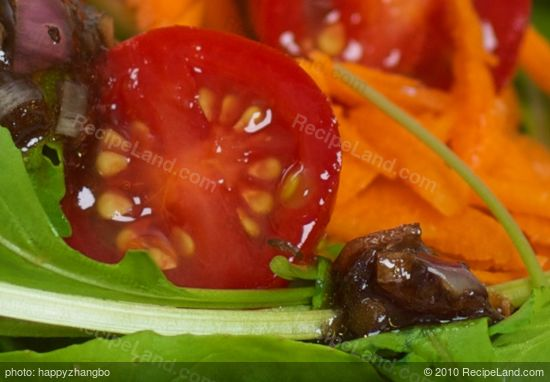

In [33]:
# Navigate to last set of subdirectories
path000 = data_dir.joinpath('0/0/0')
print("Check dir containing data subset exists", path000.exists())

image_count = len(list(path000.rglob('*.jpg')))
print("Count the number of images", image_count)

# Display examples
examples = list(path000.rglob('*.jpg'))
for image_path in examples[:1]:
    display.display(Image.open(str(image_path)))

### Load Dataset from LMDB and Images Directory

In [205]:
# Store all image path
list_ds_all = tf.data.Dataset.list_files(str(path000/'*/*'))
print(path000/'*/*')
for f in list_ds.take(5):
  print(f.numpy())

C:\Users\Joshua\classes\cs231n\chow\data\local_subset\0\0\0\*\*
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\9\\0009033123.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\0\\000069bf1c.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\0\\0000ebef8b.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\b\\000b053df5.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\0\\0000d643c9.jpg'


In [159]:
# Extract labels out of LMDB and store in dict by image id
# data_dict = convert_LMDB('..\data\test_lmdb') # this directory must contain .mdb and .lock files
# pickle.dump(data_dict, open( "data_dict_val.pkl", "wb" ) )
data_dict = pickle.load(open('../data/data_dict_val.pkl', 'rb'))
print(list(data_dict)[:5])

['05ef2f41f8.jpg', '6c98ae689b.jpg', '586f8545d5.jpg', '665bbeafc7.jpg', '87aea5035b.jpg']


In [210]:
# Some images do not have a mapping in the dictionary ...
prefix000 = [img_id for img_id in list(data_dict) if img_id[:3] == '000']
num_unlabeled = 0
for f in list_ds_all:
    foo = str(f.numpy()).split('\\')[-1][:-1] # last slice excludes ' at end of img name
    if foo not in prefix000:
        num_unlabeled += 1
print("Percent images without data_dict label: ", num_unlabeled / len(list(list_ds_all)))

Percent images without data_dict label:  0.1724137931034483


In [208]:
# Build a lookup table
category_labels = np.asarray(list(data_dict.values()))[:,1]#.astype(np.float32)
category_labels = tf.constant(category_labels, dtype=tf.float32)
print(category_labels)

img_ids = np.asarray(list(data_dict.keys()))
img_ids = tf.constant(img_ids)

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=img_ids,
        values=category_labels,
    ),
    default_value=tf.constant(-1.),
    name='categories_table'
)

input_tensor = tf.constant('0003f7346e.jpg') # from list_ds
out = table.lookup(input_tensor)
print(out)

tf.Tensor([1.044e+03 1.000e+00 1.000e+00 ... 5.900e+02 2.400e+02 1.000e+00], shape=(82093,), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


In [211]:
# Apply filtering to exclude unlabeled images
def check_labeled(img_path):
    img_id = tf.strings.split(img_path, os.path.sep)[-1]
    out = table.lookup(img_id)
    return out >= 0

list_ds = list_ds_all.filter(check_labeled)
print("Number of images in list_ds ...")
print("  originally (scraped from directories): ", len(list(list_ds_all)))
print("  after filtering out unlabeled: ", len(list(list_ds)))

Number of images in list_ds ...
  originally (scraped from directories):  29
  after filtering out unlabeled:  24


In [214]:
# Enable multiple images to process in parallel
labeled_ds = list_ds.map(lambda x: util.process_path(x, table), num_parallel_calls=AUTOTUNE) 

In [221]:
for image, label in labeled_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (385, 512, 3)
Label:  189.0
Image shape:  (256, 256, 3)
Label:  1.0
Image shape:  (1840, 3264, 3)
Label:  1.0
Image shape:  (464, 512, 3)
Label:  1.0
Image shape:  (382, 550, 3)
Label:  87.0


### Prepare Dataset for Training

In [ ]:
# Shuffle data and pre-batch so its available asap during training

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](../../guide/performance/datasets).

To investigate, first here's a function to check the performance of our datasets:

In [ ]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

A large part of the performance gain comes from the use of `.cache`.

In [ ]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:

In [ ]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)